<a href="https://colab.research.google.com/github/guifzy/Banco-C/blob/main/proj1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ucimlrepo

# Features e DataSet

1. **date**: Data no formato **dd/mm/aaaa**
2. **time**: Hora no formato **hh\:mm\:ss**
3. **global\_active\_power**: Potência ativa global média por minuto da residência (em quilowatts)
4. **global\_reactive\_power**: Potência reativa global média por minuto da residência (em quilowatts)
5. **voltage**: Tensão média por minuto (em volts)
6. **global\_intensity**: Intensidade de corrente global média por minuto da residência (em ampères)
7. **sub\_metering\_1**: Submedição de energia nº 1 (em watt-hora de energia ativa). Corresponde à cozinha, contendo principalmente lava-louças, forno e micro-ondas (as bocas do fogão não são elétricas, mas a gás).
8. **sub\_metering\_2**: Submedição de energia nº 2 (em watt-hora de energia ativa). Corresponde à lavanderia, contendo máquina de lavar, secadora, geladeira e iluminação.
9. **sub\_metering\_3**: Submedição de energia nº 3 (em watt-hora de energia ativa). Corresponde a um aquecedor de água elétrico e um ar-condicionado.


O dataset apresentado, por se tratar do consumo de energia em uma casa, implica algumas carácterísticas que devem ser levadas em consideração para modelagem posterior:
- Dependencias Lineares:
  - global_active_power segue a função (voltage * global_intensity);
  - as metricas de consumo dos aparelhos eletrônicos combinados dão um valor próximo global_active_power, o que causa multicolinearidade;
  - como a série esta em minutos, o consumo do minuto seguinte está ligado ao minuto passado, gerando dependencia temporal;

- Sazonalidade múltipla
  - Diária (picos manhã/noite, vales madrugada)

  - Semanal (dias úteis vs. fim de semana)

  - Anual (verão/inverno para aquecimento/resfriamento)

- Ruído e eventos aleatórios

  - Ligar o micro-ondas por mais de 2 min, lava roupa e ar condicionado ligados ao mesmo tempo, quedas de tensão e etc.


In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
individual_household_electric_power_consumption = fetch_ucirepo(id=235)

# data (as pandas dataframes)
X = individual_household_electric_power_consumption.data.features
y = individual_household_electric_power_consumption.data.targets

# metadata
print(individual_household_electric_power_consumption.metadata)

# variable information
print(individual_household_electric_power_consumption.variables)


/usr/local/lib/python3.12/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


{'uci_id': 235, 'name': 'Individual Household Electric Power Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/235/data.csv', 'abstract': 'Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.', 'area': 'Physics and Chemistry', 'tasks': ['Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 2075259, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2006, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C58K54', 'creators': ['Georges Hebrail', 'Alice Berard'], 'intro_paper': None, 'additional_info': {'summary': 'This archiv

In [ ]:
X

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.0,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.0,240.0,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.0,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.0,239.7,3.8,0.0,0.0,0.0


In [ ]:
X.to_csv('data.csv')

# Explorando o DataSet

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/data.csv', na_values='?')
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
df = df.set_index('Datetime')

## Imputação dos valores faltantes

In [ ]:
df.isna().sum()

,0
Date,0
Time,0
Global_active_power,25979
Global_reactive_power,25979
Voltage,25979
Global_intensity,25979
Sub_metering_1,25979
Sub_metering_2,25979
Sub_metering_3,25979


In [ ]:
df.isna().mean() * 100

,0
Date,0.000000
Time,0.000000
Global_active_power,1.251844
Global_reactive_power,1.251844
Voltage,1.251844
Global_intensity,1.251844
Sub_metering_1,1.251844
Sub_metering_2,1.251844
Sub_metering_3,1.251844


>**Imputando por interpolação temporal:** preenche os valores intermediários no eixo do tempo usando informações conhecidas em pontos vizinhos.
- Se os valores faltantes estão igualmente espaçados no tempo → o resultado é idêntico a uma interpolação linear comum.

$$
y(t^*) = y_1 + \frac{y_2 - y_1}{t_2 - t_1} \cdot (t^* - t_1)
$$

>- Se os dados têm espaçamento irregular → o method="time" calcula a proporção pelo intervalo de tempo real, criando uma curva adaptada ao eixo temporal.

$$
y(t^*) = y_1 + \frac{(t^* - t_1)}{(t_2 - t_1)} \cdot (y_2 - y_1)
$$

- $t_1, t_2$ = tempos conhecidos  
- $t^*$ = tempo a ser interpolado  
- $y_1, y_2$ = valores conhecidos  


In [ ]:
lista_interpolar = ['Global_active_power',
       'Global_reactive_power', 'Voltage', 'Global_intensity',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

df[lista_interpolar] = df[lista_interpolar].interpolate(method='time')

In [ ]:
df.isna().sum()

,0
Date,0
Time,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


## Medindo Correlação

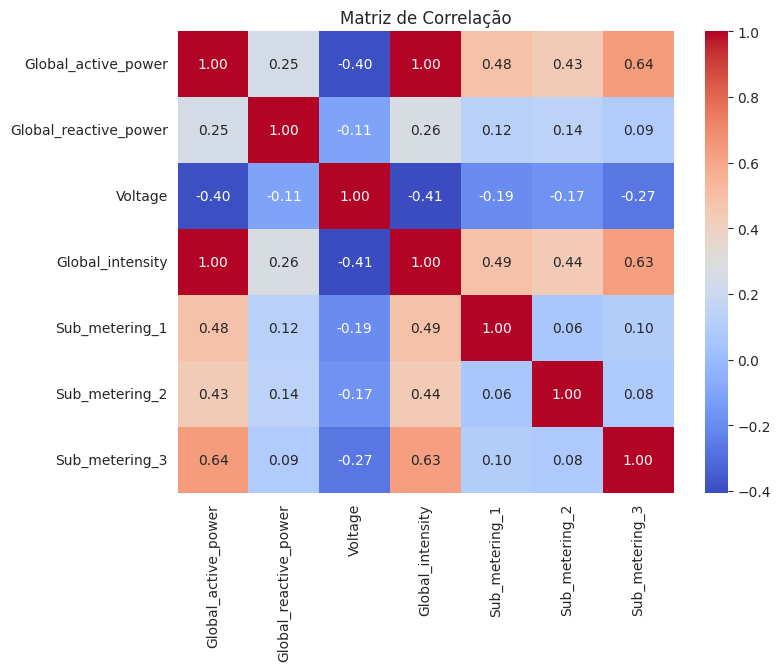

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

X = df.drop(columns=['Global_active_power', 'Date', 'Time'])
X_const = add_constant(X)

vif = pd.DataFrame()
vif["Variável"] = X.columns
vif["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]
print(vif)


                Variável       VIF
0  Global_reactive_power  1.088825
1                Voltage  1.199281
2       Global_intensity  3.854411
3         Sub_metering_1  1.605083
4         Sub_metering_2  1.492166
5         Sub_metering_3  2.114421


Por ter uma alta correlação, o que se explica por meio de $global \space active \space power=voltage * global \space intensity$, e por ser uma variável determinística do taget, esta variável será descartada visando evitar overfitting.

In [ ]:
df = df.drop(columns=['Global_intensity'])

In [ ]:
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.84,0.0,1.0,17.0
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.63,0.0,1.0,16.0
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.29,0.0,2.0,17.0
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.74,0.0,1.0,17.0
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.68,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,26/11/2010,20:58:00,0.946,0.000,240.43,0.0,0.0,0.0
2010-11-26 20:59:00,26/11/2010,20:59:00,0.944,0.000,240.00,0.0,0.0,0.0
2010-11-26 21:00:00,26/11/2010,21:00:00,0.938,0.000,239.82,0.0,0.0,0.0


## Outliers

In [ ]:
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df["Time"] = pd.to_datetime(df["Time"], format="%H:%M:%S")
df["Dia_semana"] = df["Date"].dt.day_name()
df["Mes"] = df["Date"].dt.month
df["Hora"] = df["Time"].dt.hour
df['Ano'] = df["Date"].dt.year

- Analisando as distribuições para cada coluna em um intervalo de ano

In [ ]:
for ano in df['Ano'].unique():
    subset = df[df['Ano']==ano]
    print(ano)
    print(subset.describe())
    print()

2006
                                Date                           Time  \
count                          21996                          21996   
mean   2006-12-23 20:32:36.137479424  1900-01-01 12:08:53.862520320   
min              2006-12-16 00:00:00            1900-01-01 00:00:00   
25%              2006-12-20 00:00:00            1900-01-01 06:06:00   
50%              2006-12-24 00:00:00            1900-01-01 12:13:00   
75%              2006-12-28 00:00:00            1900-01-01 18:16:00   
max              2006-12-31 00:00:00            1900-01-01 23:59:00   
std                              NaN                            NaN   

       Global_active_power  Global_reactive_power       Voltage  \
count         21996.000000           21996.000000  21996.000000   
mean              1.901564               0.131398    241.440787   
min               0.194000               0.000000    228.200000   
25%               0.496000               0.000000    238.750000   
50%               1.

- O dataset não é uniforme no primeiro e último ano, não irei trabalhar com médias globais;
- Média de consumo decrescente, reforça a mudança de estilo de vida,climáticas ou até mesmo aparelhos domesticos mais econômicos, trabalhar com diferentes granularidades;
- Pouca flutuação na voltagem, mas em alta granularidade podem existir picos de energia.

> Como estou procurando picos gerais de uso na casa (ar condicionaod e lava roupas aos mesmo tempo), vou visualizar a distribuição dos dados utilizando o consumo global.

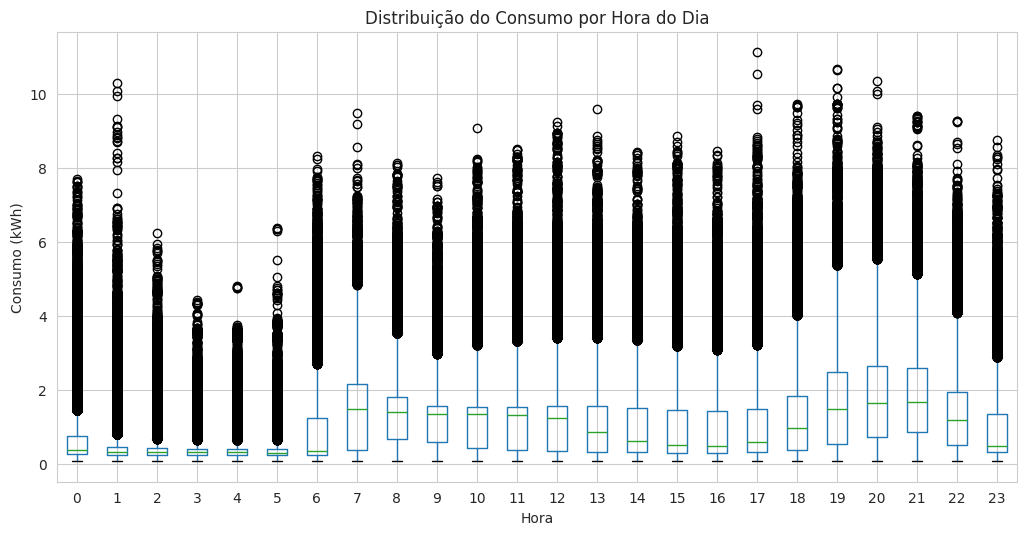

In [ ]:
df.boxplot(column="Global_active_power", by="Hora", figsize=(12,6))
plt.title("Distribuição do Consumo por Hora do Dia")
plt.suptitle("")
plt.xlabel("Hora")
plt.ylabel("Consumo (kWh)")
plt.show()

- Aplicar rolling para identificar quando existiram picos de energia de hora em hora baseandos na média e desvio padrão do consumo global (z-score), separados por ano e mês (evitar impactos de sazonalidade e mudanças de aparelho domesticos e etc).

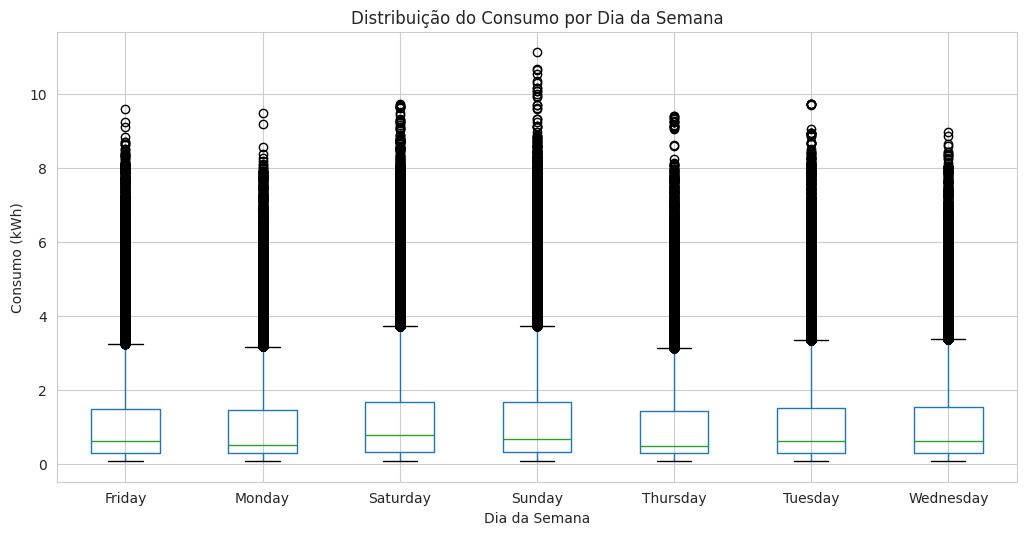

In [ ]:
df.boxplot(column="Global_active_power", by="Dia_semana", figsize=(12,6))
plt.title("Distribuição do Consumo por Dia da Semana")
plt.suptitle("")
plt.xlabel("Dia da Semana")
plt.ylabel("Consumo (kWh)")
plt.show()

- Realizar o mesmo processo, porém com maior granularidade, visando identificar dias onde o consumo não segue o padrão diario esperado utilizando o z-score.

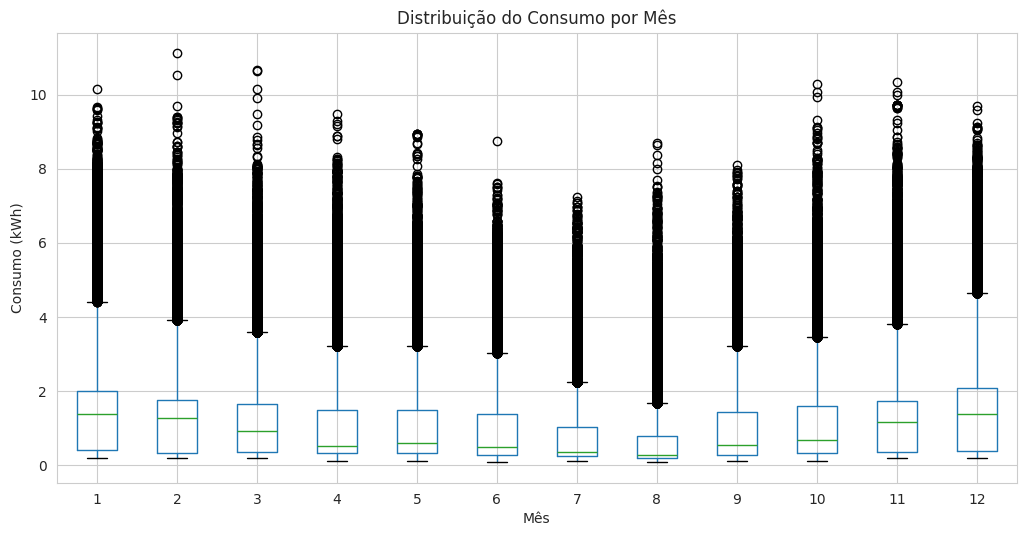

In [ ]:
df.boxplot(column="Global_active_power", by="Mes", figsize=(12,6))
plt.title("Distribuição do Consumo por Mês")
plt.suptitle("")
plt.xlabel("Mês")
plt.ylabel("Consumo (kWh)")
plt.show()

- Decompor minha série para identifcar sazonalidades explicitas, como maior gasto energetico no verão ou no inverno.

### Análise de Padrões

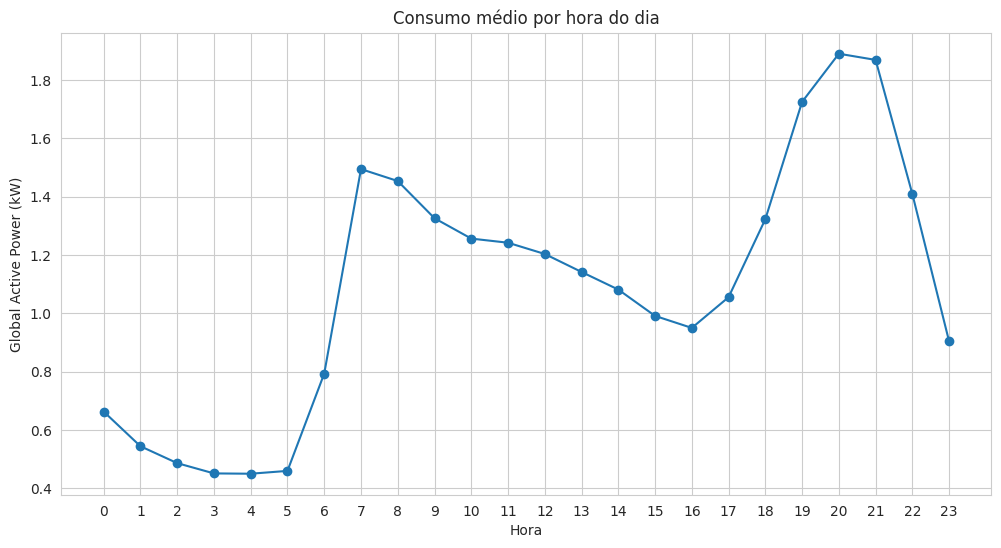

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

hourly_mean = df.groupby('Hora')['Global_active_power'].mean()
plt.plot(hourly_mean.index, hourly_mean.values, marker='o')
plt.title('Consumo médio por hora do dia')
plt.xlabel('Hora')
plt.ylabel('Global Active Power (kW)')
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

- Picos claros as 7h e entre 19h e 21h, vale a pena a criação de rolling para as horas anteriores, além da sen/cos para tendências de comportamento

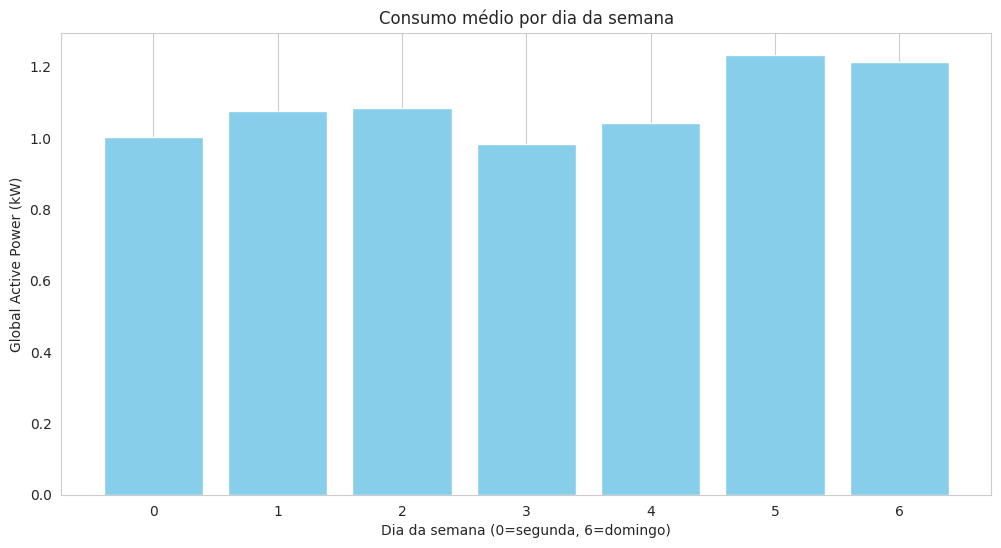

In [ ]:
df['Dia_semana'] = df['Date'].dt.dayofweek  # 0=segunda, 6=domingo
dow_mean = df.groupby('Dia_semana')['Global_active_power'].mean()

plt.bar(dow_mean.index, dow_mean.values, color='skyblue')
plt.title('Consumo médio por dia da semana')
plt.xlabel('Dia da semana (0=segunda, 6=domingo)')
plt.ylabel('Global Active Power (kW)')
plt.grid(axis='y')
plt.show()

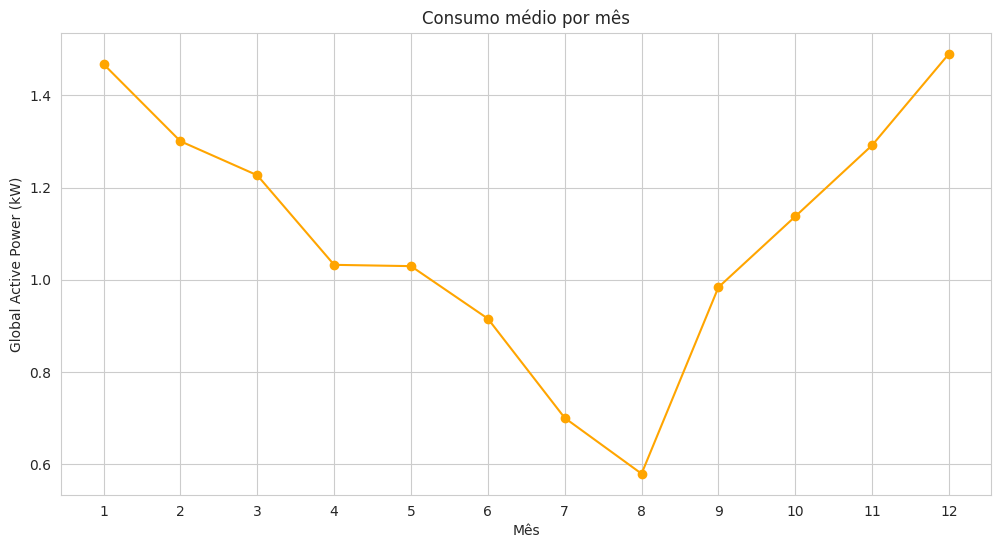

In [ ]:
monthly_mean = df.groupby('Mes')['Global_active_power'].mean()

plt.plot(monthly_mean.index, monthly_mean.values, marker='o', color='orange')
plt.title('Consumo médio por mês')
plt.xlabel('Mês')
plt.ylabel('Global Active Power (kW)')
plt.xticks(range(1,13))
plt.grid(True)
plt.show()

- Aumento no consumo durante o inverno (provavelmente por conta do uso de aquecedores), criação de Lags e sen/cos para sazonalidade

### Sazonalidades

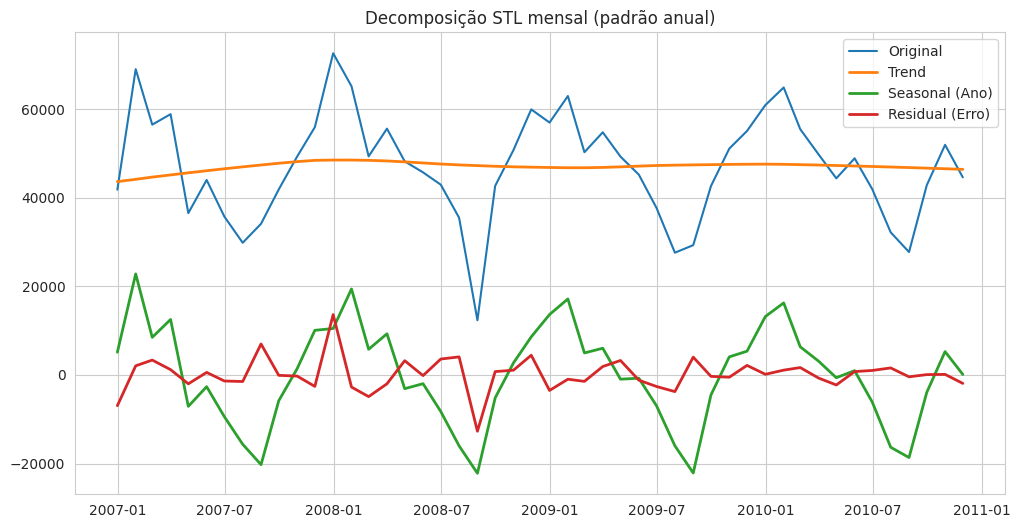

In [ ]:
from statsmodels.tsa.seasonal import STL

df_mes = df.resample('ME')['Global_active_power'].sum()

stl_mes = STL(df_mes, period=12)
res_mes = stl_mes.fit()

plt.figure(figsize=(12,6))
plt.plot(df_mes, label='Original')
plt.plot(res_mes.trend, label='Trend', linewidth=2)
plt.plot(res_mes.seasonal, label='Seasonal (Ano)', linewidth=2)
plt.plot(res_mes.resid, label='Residual (Erro)', linewidth=2)
plt.legend()
plt.title('Decomposição STL mensal (padrão anual)')
plt.show()

- Sazonalide explicita, provavlemente por conta das estações do ano, e erro sem picos evidente, com tendencia leve de queda.

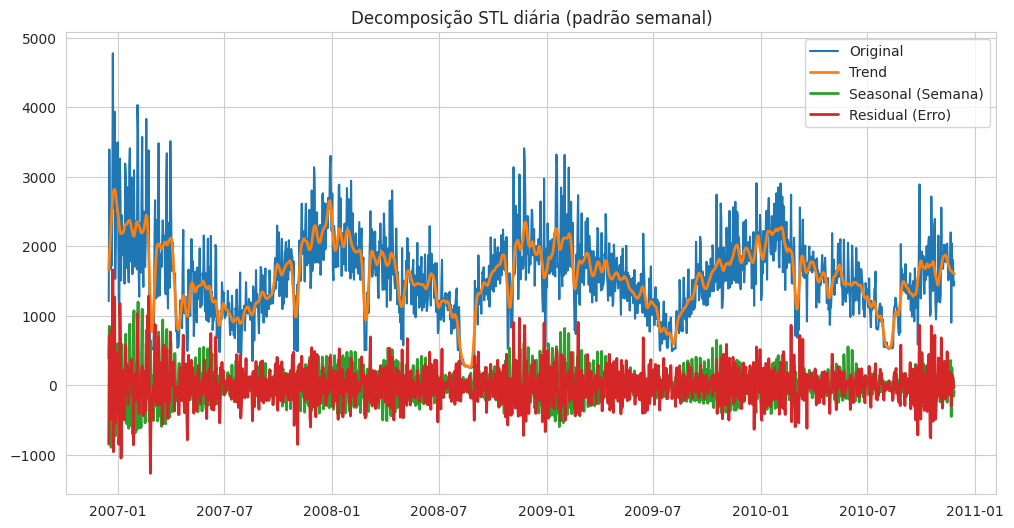

In [ ]:
df_diario = df.resample('D')['Global_active_power'].sum()

stl_diario = STL(df_diario, period=7)
res_diario = stl_diario.fit()

plt.figure(figsize=(12,6))
plt.plot(df_diario, label='Original')
plt.plot(res_diario.trend, label='Trend', linewidth=2)
plt.plot(res_diario.seasonal, label='Seasonal (Semana)', linewidth=2)
plt.plot(res_diario.resid, label='Residual (Erro)', linewidth=2)
plt.legend()
plt.title('Decomposição STL diária (padrão semanal)')
plt.show()

- Picos de ruído expressíveis e sem sazonalidade explícita, com tendencia a longo prazo que reforça sazonalide climática

## Criação de Features Adicionais

> Criando rolling para identificar picos de energia em um intervalo de 1 hora, aproveitando também para cirar features de rolling para alimentar o MLP.

>Aqui estou verificando o z-score baseado na média de 1 hora antes e 1 hora depois de cada ponto.
$$z=\frac{x-μ}{𝞭}$$
- x = valor observado
- μ = média da distribuição
- 𝞭 = desvio padrão

Assim, é possível determinar em até quantos desvios padrões deve-se considerar um outlier

In [ ]:
window_size = 60  # janela de 1 hora, 60 linhas

for ano in df['Ano'].unique():
    for mes in df[df['Ano']==ano]['Mes'].unique():
        subset = df[(df['Ano']==ano) & (df['Mes']==mes)].copy()

        subset['rolling_mean_peak'] = subset['Global_active_power'].rolling(window=window_size, center=True).mean()
        subset['rolling_std_peak'] = subset['Global_active_power'].rolling(window=window_size, center=True).std()

        subset['rolling_mean_peak'] = subset['rolling_mean_peak'].bfill()
        subset['rolling_mean_peak'] = subset['rolling_mean_peak'].ffill()
        subset['rolling_std_peak'] = subset['rolling_std_peak'].bfill()
        subset['rolling_std_peak'] = subset['rolling_std_peak'].ffill()

        subset['outlier_hora'] = ((subset['Global_active_power'] - subset['rolling_mean_peak']).abs() > 3*subset['rolling_std_peak']).astype(int)

        # features de rolling pro mlp
        subset['rolling_mean_mlp'] = subset['Global_active_power'].rolling(window=window_size, min_periods=1, center=False).mean()
        subset['rolling_std_mlp'] = subset['Global_active_power'].rolling(window=window_size, min_periods=1, center=False).std()

        col = ['outlier_hora', 'rolling_mean_mlp', 'rolling_std_mlp']
        df.loc[subset.index, col] = subset[col]


In [ ]:
df['rolling_std_mlp'] = df['rolling_std_mlp'].fillna(0)

> Criando flag para outlier de dia, separado por anos, também utilizando o z-score.

In [ ]:
from scipy.stats import zscore

df_daily = df['Global_active_power'].resample('D').sum().to_frame()
df_daily['Ano'] = df_daily.index.year

df_daily['zscore'] = df_daily.groupby('Ano')['Global_active_power'].transform(
    lambda x: zscore(x, nan_policy='omit')
)
df_daily['outlier_dia'] = (df_daily['zscore'].abs() > 3).astype(int)

df['outlier_dia'] = df_daily['outlier_dia'].reindex(df.index.date, method='ffill').values

In [ ]:
df['outlier_dia'].value_counts()

,count
outlier_dia,
0,2065179
1,10080


In [ ]:
df['outlier_hora'].value_counts()

,count
outlier_hora,
0.0,2052556
1.0,22703


O sen e cos se baseia na idea de transformar as variáveis em circulares, indicando ao modelo que os horários e ciclos (dias da semana e meses), são circulares.

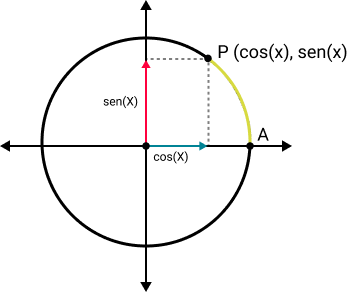

In [ ]:
df['hora_sen'] = np.sin(2 * np.pi * df['Hora'] / 24)
df['hora_cos'] = np.cos(2 * np.pi * df['Hora'] / 24)

df['dia_semana_sen'] = np.sin(2 * np.pi * df['Dia_semana'] / 7)
df['dia_semana_cos'] = np.cos(2 * np.pi * df['Dia_semana'] / 7)

df['mes_sen'] = np.sin(2 * np.pi * (df['Mes']-1) / 12)
df['mes_cos'] = np.cos(2 * np.pi * (df['Mes']-1) / 12)

Como este dataset apresenta os valores de minuto a minuto, o comportamento dos dados apresentam dependencia temporal, o que implica que, o consumo de energia às 15:00h depende do que aconteceu às 14:59h e etc.

São criados Lags para mostrar ao modelo o que aconteceu no minuto, hora, dia e até mes anterior.

Lags utilizados:

- Minuto a minuto: captura a inércia imediata dos aparelhos ligados; o consumo recente influencia fortemente o próximo instante.

- Hora a hora: reflete padrões de rotina e ciclos diários curtos, como horários de pico e uso de equipamentos.

- Dia a dia: evidencia padrões sazonais mais longos, como consumo no mesmo horário em dias diferentes ou dias da semana, permitindo ao modelo aprender repetições regulares.

In [ ]:
df['lag_1'] = df['Global_active_power'].shift(1)
df['lag_60'] = df['Global_active_power'].shift(60)
df['lag_1440'] = df['Global_active_power'].shift(1440)

In [ ]:
df.isnull().sum()

,0
Date,0
Time,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0
Dia_semana,0
Mes,0


> Os valores vazios nos lags existem porque no início da série não há dados anteriores suficientes para calcular o lag_1, lag_60 ou lag_1440.

  - Para sinalizar isso ao modelo é criado uma coluna (lag_vazio) para indicar quais linhas tiveram lags faltantes.

  - Já os valores vazios são preenchidos com a mediana de cada coluna de lag, preservando a tendência central sem distorcer o modelo.

In [ ]:
lag_cols = ['lag_1', 'lag_60', 'lag_1440']

df['lag_vazio'] = df[lag_cols].isna().any(axis=1).astype(int)
fill_values = df[lag_cols].median()
df[lag_cols] = df[lag_cols].fillna(fill_values)

# Treinando a rede

In [ ]:
df.columns

Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
       'Dia_semana', 'Mes', 'Hora', 'Ano', 'outlier_hora', 'rolling_mean_mlp',
       'rolling_std_mlp', 'outlier_dia', 'hora_sen', 'hora_cos',
       'dia_semana_sen', 'dia_semana_cos', 'mes_sen', 'mes_cos', 'lag_1',
       'lag_60', 'lag_1440', 'lag_vazio'],
      dtype='object')

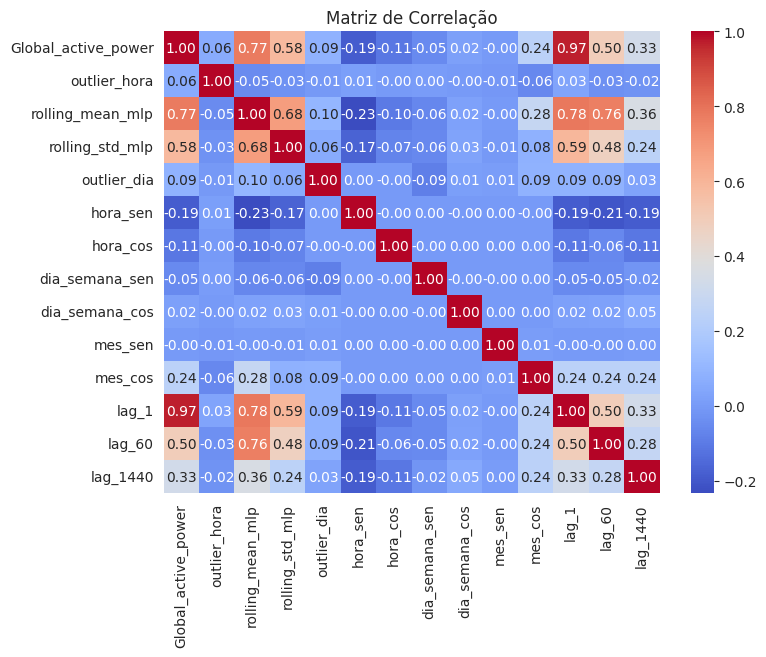

In [ ]:
corr = df[['Global_active_power', 'outlier_hora', 'rolling_mean_mlp',
       'rolling_std_mlp', 'outlier_dia', 'hora_sen', 'hora_cos',
       'dia_semana_sen', 'dia_semana_cos', 'mes_sen', 'mes_cos', 'lag_1',
       'lag_60', 'lag_1440']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlação")
plt.show()

## Escalando as features

In [ ]:
from sklearn.preprocessing import StandardScaler

# não irei incluir rolling mean por ser redundante já que estou incluindo os lags
features = [
    'Global_reactive_power',
    'Voltage', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'rolling_std_mlp',  'lag_1',
    'lag_60', 'lag_1440'
]

features_ciclicas = [
    'hora_sen', 'hora_cos',
    'dia_semana_sen', 'dia_semana_cos', 'mes_sen', 'mes_cos',]

features_binarias = ['outlier_hora', 'outlier_dia', 'lag_vazio']
target = 'Global_active_power'

train_df = df[df['Ano'] < 2010]
test_df = df[df['Ano'] == 2010]

X_train_cont = train_df[features]
X_train_bin = train_df[features_binarias]
X_train_ciclico = train_df[features_ciclicas]
y_train = train_df[target]

X_test_cont = test_df[features]
X_test_bin = test_df[features_binarias]
X_test_ciclico = test_df[features_ciclicas]
y_test = test_df[target]


In [ ]:
scaler = StandardScaler()
X_train_cont_scaled = scaler.fit_transform(X_train_cont)
X_test_cont_scaled = scaler.transform(X_test_cont)
X_train_ciclico_scaled = scaler.fit_transform(X_train_ciclico)
X_test_ciclico_scaled = scaler.transform(X_test_ciclico)

- Adicionando ruido gausiano para penalizaçao de features muito explicativas

In [ ]:
sigma = 0.01
noise = np.random.normal(loc=0, scale=sigma, size=X_train_cont_scaled.shape)
X_train_cont_noisy = X_train_cont_scaled + noise

In [ ]:
X_train_final = np.concatenate([X_train_cont_noisy, X_train_bin.values, X_train_ciclico_scaled], axis=1)
X_test_final = np.concatenate([X_test_cont_scaled, X_test_bin.values, X_test_ciclico_scaled], axis=1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

print("Treino: ", X_train_tensor.shape, y_train_tensor.shape)
print("Teste: ",X_test_tensor.shape, y_test_tensor.shape)

Treino:  torch.Size([1600236, 18]) torch.Size([1600236, 1])
Teste:  torch.Size([475023, 18]) torch.Size([475023, 1])


## Arquitetura da Rede

In [ ]:
class ConsumoMLP(nn.Module):
    def __init__(self, input_dim):
        super(ConsumoMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model = ConsumoMLP(X_train_tensor.shape[1])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

- Treinamento

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0: # 5 em 5
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [5/100], Loss: 0.1440
Epoch [10/100], Loss: 0.1341
Epoch [15/100], Loss: 0.1245
Epoch [20/100], Loss: 0.1171
Epoch [25/100], Loss: 0.1117
Epoch [30/100], Loss: 0.1067
Epoch [35/100], Loss: 0.1025
Epoch [40/100], Loss: 0.0986
Epoch [45/100], Loss: 0.0949
Epoch [50/100], Loss: 0.0916
Epoch [55/100], Loss: 0.0884
Epoch [60/100], Loss: 0.0855
Epoch [65/100], Loss: 0.0827
Epoch [70/100], Loss: 0.0800
Epoch [75/100], Loss: 0.0776
Epoch [80/100], Loss: 0.0753
Epoch [85/100], Loss: 0.0732
Epoch [90/100], Loss: 0.0713
Epoch [95/100], Loss: 0.0696
Epoch [100/100], Loss: 0.0680


## Validando o modelo

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    mse_loss = criterion(predictions, y_test_tensor)
    mae_loss = torch.mean(torch.abs(predictions - y_test_tensor))
    print(f'Mean Squared Error on Test Set: {mse_loss.item():.4f}')
    print(f'Mean Absolute Error on Test Set: {mae_loss.item():.4f}')

Mean Squared Error on Test Set: 0.0490
Mean Absolute Error on Test Set: 0.1418


/tmp/ipython-input-1793894308.py:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_plot.resample('H', on='Date').mean()


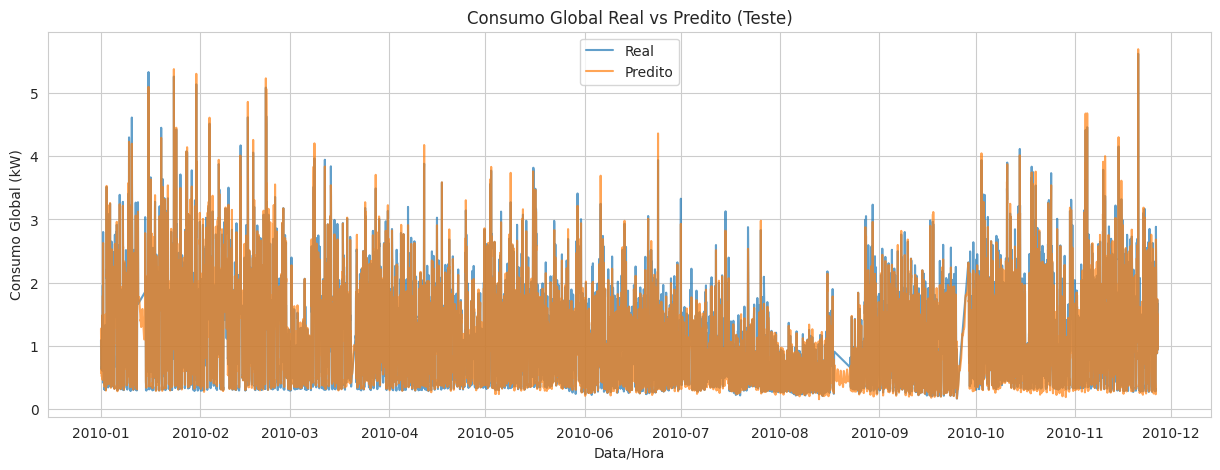

In [ ]:
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)

# Converter tensores para arrays numpy
y_pred = y_pred_tensor.numpy().flatten()
y_true = y_test_tensor.numpy().flatten()

# Criar DataFrame para plot
df_plot = pd.DataFrame({
    'real': y_true,
    'predito': y_pred,
    'Date': test_df['Date'] + pd.to_timedelta(test_df['Hora'], unit='h')  # reconstruindo timestamp completo
})

# Opcional: agrupar por hora para visualização mais clara
df_hourly = df_plot.resample('H', on='Date').mean()

plt.figure(figsize=(15,5))
plt.plot(df_hourly.index, df_hourly['real'], label='Real', alpha=0.7)
plt.plot(df_hourly.index, df_hourly['predito'], label='Predito', alpha=0.7)
plt.xlabel('Data/Hora')
plt.ylabel('Consumo Global (kW)')
plt.title('Consumo Global Real vs Predito (Teste)')
plt.legend()
plt.show()
